In [ ]:
# import library 
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import optuna
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



In [3]:
# fetch dataset
auto_mpg = fetch_ucirepo(id=9)
X = auto_mpg.data.features
y = auto_mpg.data.targets


df = pd.concat([X, y], axis=1)

print("=== Informasi Dataset ===")
print(df.info())
print("\n=== Statistik Deskriptif ===")
print(df.describe())
print("\n=== Missing Values ===")
print(df.isnull().sum())



=== Informasi Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   displacement  398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   horsepower    392 non-null    float64
 3   weight        398 non-null    int64  
 4   acceleration  398 non-null    float64
 5   model_year    398 non-null    int64  
 6   origin        398 non-null    int64  
 7   mpg           398 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 25.0 KB
None

=== Statistik Deskriptif ===
       displacement   cylinders  horsepower       weight  acceleration  \
count    398.000000  398.000000  392.000000   398.000000    398.000000   
mean     193.425879    5.454774  104.469388  2970.424623     15.568090   
std      104.269838    1.701004   38.491160   846.841774      2.757689   
min       68.000000    3.000000   46.000000  1613.000000  

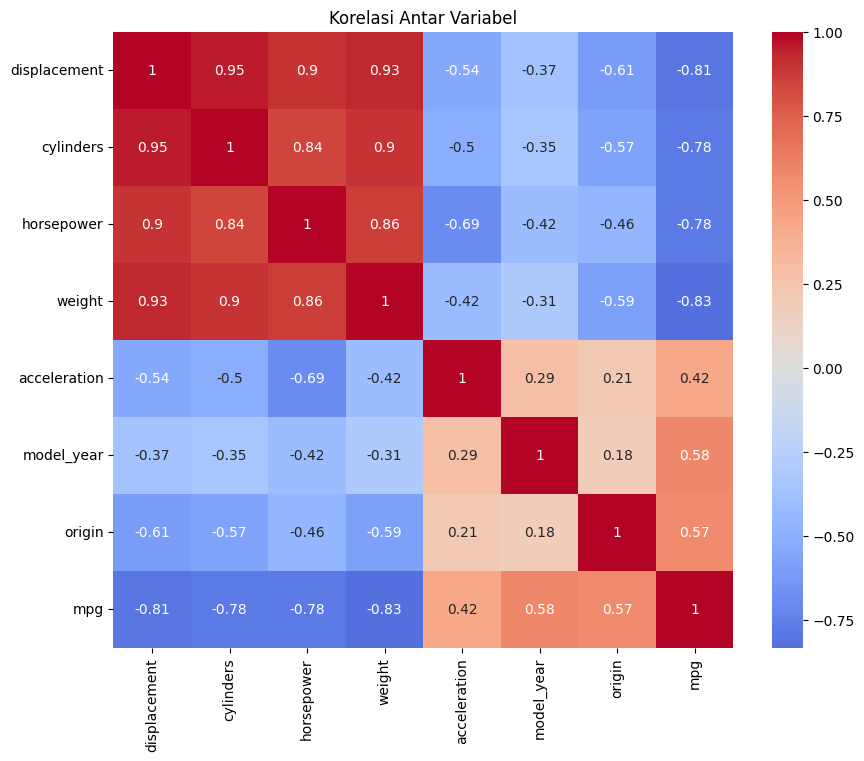

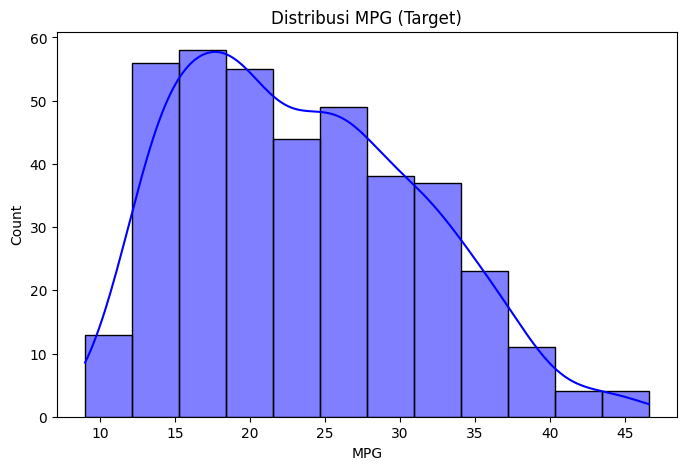

In [ ]:
# EDA dan Preprocessing
# ganti '?' dengan NaN lalu drop semua baris yang punya NaN
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

# konversi kolom numerik ke tipe data yang benar
df = df.astype({
    'cylinders': 'int64',
    'displacement': 'float64',
    'horsepower': 'float64',
    'weight': 'float64',
    'acceleration': 'float64',
    'model_year': 'int64',
    'origin': 'object',
    'mpg': 'float64'
})

# pisahkan fitur dan target
X = df.drop(columns=['mpg'])
y_log = np.log(df['mpg'])
# visualisasi korelasi 
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Korelasi Antar Variabel')
plt.show()

# visualisasi distribusi target 
plt.figure(figsize=(8, 5))
sns.histplot(df['mpg'], kde=True, color='blue')
plt.title('Distribusi MPG (Target)')
plt.xlabel('MPG')
plt.show()

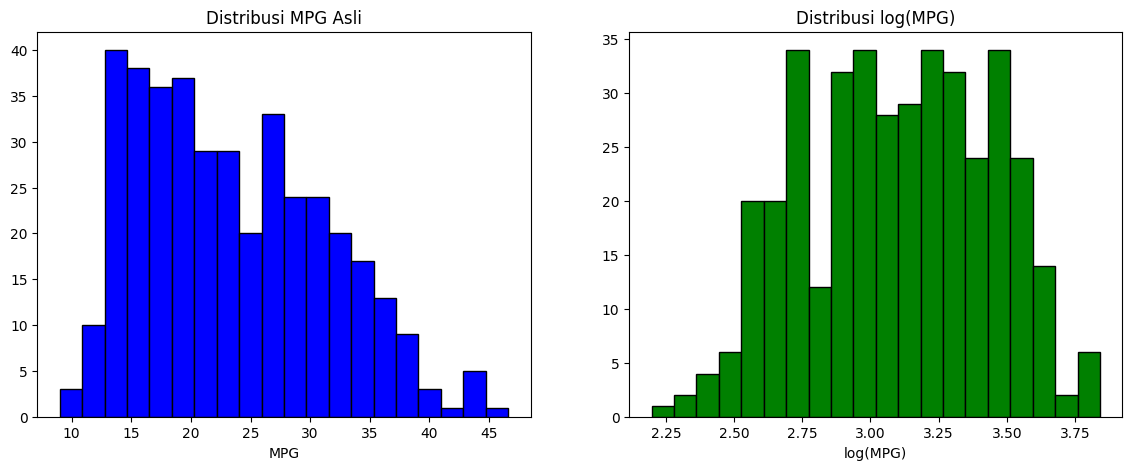

In [ ]:
# transformasi TARGET (MPG) → log transformation
y_log = np.log(df['mpg'])  # Lebih stabil dan mendekati normal

# visualisasi sebelum & sesudah transformasi target
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].hist(df['mpg'], bins=20, color='blue', edgecolor='black')
ax[0].set_title('Distribusi MPG Asli')
ax[0].set_xlabel('MPG')

ax[1].hist(y_log, bins=20, color='green', edgecolor='black')
ax[1].set_title('Distribusi log(MPG)')
ax[1].set_xlabel('log(MPG)')

plt.show()

In [ ]:
numeric_features = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
categorical_features = ['origin']

#preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),   # Standarisasi numerik
        ('cat', OneHotEncoder(drop='first'), categorical_features)     # One-hot encoding nanti di dalam pipeline
    ],
    remainder='drop'  # Hapus kolom lain
)

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [ ]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.001, 100.0, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    # pipeline: preprocessor + model
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=1000))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)

best_params = study.best_params
print("\n=== Hyperparameter Terbaik ===")
print(best_params)

# model final
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(**best_params, max_iter=1000))
])
final_pipeline.fit(X_train, y_train)

# pred
y_pred_log = final_pipeline.predict(X_test)
y_pred_original = np.exp(y_pred_log)
y_test_original = np.exp(y_test)  # Balikin target ke skala asli

# Evaluasi
r2_original = r2_score(y_test_original, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

print("\n=== Hasil Evaluasi Model (Skala Asli) ===")
print(f"R² Score: {r2_original:.4f}")
print(f"RMSE: {rmse_original:.4f}")

# koefisien 
coefficients = final_pipeline.named_steps['regressor'].coef_
# Ambil nama fitur dari preprocessor
feature_names = (
    numeric_features +
    list(final_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
)
coeff_df = pd.DataFrame(coefficients, feature_names, columns=['Coefficient'])
print("\n=== Koefisien Model ===")
print(coeff_df)

[I 2025-10-26 21:49:33,912] A new study created in memory with name: no-name-2acb2bf7-7c18-4504-9a9b-1f7d577229b9
[I 2025-10-26 21:49:33,924] Trial 0 finished with value: 0.1137756314381009 and parameters: {'alpha': 0.07125167361279319, 'l1_ratio': 0.3389924853332177}. Best is trial 0 with value: 0.1137756314381009.
[I 2025-10-26 21:49:33,933] Trial 1 finished with value: 0.11856779300688555 and parameters: {'alpha': 0.15473496077050497, 'l1_ratio': 0.010130083059518569}. Best is trial 0 with value: 0.1137756314381009.
[I 2025-10-26 21:49:33,942] Trial 2 finished with value: 0.11698498866245678 and parameters: {'alpha': 0.0014065561964777121, 'l1_ratio': 0.8327994855679226}. Best is trial 0 with value: 0.1137756314381009.
[I 2025-10-26 21:49:33,950] Trial 3 finished with value: 0.17584096172844038 and parameters: {'alpha': 1.7724896473239176, 'l1_ratio': 0.03497291618491838}. Best is trial 0 with value: 0.1137756314381009.
[I 2025-10-26 21:49:33,958] Trial 4 finished with value: 0.1152


=== Hyperparameter Terbaik ===
{'alpha': 0.02340487150777491, 'l1_ratio': 0.9993774280622331}

=== Hasil Evaluasi Model (Skala Asli) ===
R² Score: 0.8564
RMSE: 2.7069

=== Koefisien Model ===
              Coefficient
cylinders       -0.020810
displacement    -0.001559
horsepower      -0.029318
weight          -0.201461
acceleration     0.000000
model_year       0.093926
origin_2         0.000000
origin_3         0.000000
